In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/countycrimedata/2022-10-leicestershire-street.csv
/kaggle/input/countycrimedata/2022-06-kent-street.csv
/kaggle/input/countycrimedata/2022-11-derbyshire-street.csv
/kaggle/input/countycrimedata/2022-07-kent-street.csv
/kaggle/input/countycrimedata/2022-02-leicestershire-street.csv
/kaggle/input/countycrimedata/2022-10-derbyshire-street.csv
/kaggle/input/countycrimedata/2022-03-kent-street.csv
/kaggle/input/countycrimedata/2022-07-leicestershire-street.csv
/kaggle/input/countycrimedata/2022-02-kent-street.csv
/kaggle/input/countycrimedata/2022-09-kent-street.csv
/kaggle/input/countycrimedata/2022-02-derbyshire-street.csv
/kaggle/input/countycrimedata/2022-01-derbyshire-street.csv
/kaggle/input/countycrimedata/2022-08-derbyshire-street.csv
/kaggle/input/countycrimedata/2022-11-leicestershire-street.csv
/kaggle/input/countycrimedata/2022-06-derbyshire-street.csv
/kaggle/input/countycrimedata/2022-11-kent-street.csv
/kaggle/input/countycrimedata/2022-06-leicestershire-street.

In [3]:
#Install pyspark
!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 10.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805894 sha256=0eaab353561d48c04181accaa17ce29730af47c6d4fb1cbcf7f0857e655b8ac2
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [4]:
#start spark session and configuration
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("CrimeDataAnalysis").getOrCreate()
sc = spark.sparkContext
#create an instance of SQLContext
sqlContext = SQLContext(spark)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/14 13:53:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
#Import libraries and other functions
from pyspark.sql import Row
from pyspark.sql.types import*
from pyspark.sql.functions import*
from pyspark.sql import functions as F
from itertools import chain
import csv
import pandas as pd
import numpy as np


In [6]:
#Loading all csv files in one data frame.
CountyCrime = spark.read.option("header", "true").option("delimiter", ",").option("inferSchema", "true").csv("/kaggle/input/countycrimedata/*street.csv")

In the above code we load all csv files in one data frame which i named CountyCrime using wildcard (*).

In [7]:
#usnig print schema
CountyCrime.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [8]:
#tidy up the column name
CountyCrime = CountyCrime.withColumnRenamed('Crime ID', 'Crime_ID')
CountyCrime = CountyCrime.withColumnRenamed('Reported by', 'Reported_By')
CountyCrime = CountyCrime.withColumnRenamed('Falls within', 'Falls_Within')
CountyCrime = CountyCrime.withColumnRenamed('LSOA code', 'LSOA_Code')
CountyCrime = CountyCrime.withColumnRenamed('LSOA name', 'LSOA_Name')
CountyCrime = CountyCrime.withColumnRenamed('crime type', 'Crime_Type')
CountyCrime = CountyCrime.withColumnRenamed('Last outcome category', 'Last_OutCome_Category')

In this code we use withColumnRenamed to renamed to some columns to make it easy to read 
such as we change Crime ID to Crime_ID and similarly we change some more
columns.

In [9]:

CountyCrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_By: string (nullable = true)
 |-- Falls_Within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_Code: string (nullable = true)
 |-- LSOA_Name: string (nullable = true)
 |-- Crime_Type: string (nullable = true)
 |-- Last_OutCome_Category: string (nullable = true)
 |-- Context: string (nullable = true)



In the above code we successfully changed our columns named

In [10]:
#Print first 5 lines of data
CountyCrime.show(5)

+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|            Crime_ID|  Month|Reported_By|Falls_Within|Longitude| Latitude|            Location|LSOA_Code|   LSOA_Name|          Crime_Type|Last_OutCome_Category|Context|
+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|b93c5583a3adce8a0...|2022-08|Kent Police| Kent Police| 0.973355|51.260972|On or near Lower ...|E01023987|Ashford 001B|            Burglary| Investigation com...|   null|
|330e17b2dc5af6854...|2022-08|Kent Police| Kent Police| 0.963316|51.258906|On or near New Fo...|E01023987|Ashford 001B|Criminal damage a...| Investigation com...|   null|
|794686e451d00c2c8...|2022-08|Kent Police| Kent Police| 0.958126|51.259568|On or near New Fo...|E01023987|Ashford 001B|         Other theft| Inve

In [11]:
#Create a DataFrame from a list of tuples, representing the Reported_By column
CountyCrime_mapping = sc.parallelize([('Derbyshire Constabulary', ), ('Leicestershire Police', ), ('Kent Police', )]).toDF(['Reported_By'])

#Create a dictionary that maps police force names to county names
dictionary = {'Derbyshire Constabulary': 'Derbyshire', 'Leicestershire Police': 'Leicestershire', 'Kent Police': 'Kent'}

#Create mapping expresssoion using dictionary
#Create_map function creates a map from the key value pairs in the dictionary
mapping_expr = create_map([lit(x) for x in chain(*dictionary.items())])

#Add a new column County to the DataFrame
#Using mapping expression bases on Reported_By column
CountyCrime_mapping= CountyCrime_mapping.withColumn("County", mapping_expr[col("Reported_By")])

#Display the result with new column 'County'
CountyCrime_mapping.show(truncate=False)

+-----------------------+--------------+
|Reported_By            |County        |
+-----------------------+--------------+
|Derbyshire Constabulary|Derbyshire    |
|Leicestershire Police  |Leicestershire|
|Kent Police            |Kent          |
+-----------------------+--------------+



In this code we start by creating a DataFrame from a list of tuple, where each tuple contains the name of a police force.

Next, we define a dictionary that maps the names of police forces with their corresponding counties.

Then,we use create_map function to create mapping expression that converts each police force in the Reported_By column to the corresponding county from the dictionary.

After that,using the mapping expression we create a new column County in the DataFrame.

At last we display the result.

**KeyPoint:**
In above code i use lit and chain function.
The lit function in the above code is used to convert each key and value from the dictionary into a literal value tha can be processes by Spark.
It is important when working with mapping expression using create_map the function expects literal  values as argument.

I also use chain that is used to unpack the keyvalue pairs from the dictionary into a flat list. The dictionary.items returns a view of the dictionary items as tuples. When passed to chain it flatten these tuples into single sequence of elements.

In [12]:
#Join the CountyCrime DataFrame with the CountyCrime_mapping. It is based on the Reported_By column from both DataFrames.
countycrime_joined = CountyCrime.join(CountyCrime_mapping, on=['Reported_By'], how='left')

#Display the first five rows
countycrime_joined.show(5)

+-----------+--------------------+-------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+------+
|Reported_By|            Crime_ID|  Month|Falls_Within|Longitude| Latitude|            Location|LSOA_Code|   LSOA_Name|          Crime_Type|Last_OutCome_Category|Context|County|
+-----------+--------------------+-------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+------+
|Kent Police|b93c5583a3adce8a0...|2022-08| Kent Police| 0.973355|51.260972|On or near Lower ...|E01023987|Ashford 001B|            Burglary| Investigation com...|   null|  Kent|
|Kent Police|330e17b2dc5af6854...|2022-08| Kent Police| 0.963316|51.258906|On or near New Fo...|E01023987|Ashford 001B|Criminal damage a...| Investigation com...|   null|  Kent|
|Kent Police|794686e451d00c2c8...|2022-08| Kent Police| 0.958126|51.259568|On or near New Fo...|E01023987|Ashf

**Keypoint**
A left join ensures all records from CountyCrime are Kept and matching from CountyCrime_mapping are added to the result.

In [13]:

#Register the DataFrame as a temporary SQL tabel
countycrime_joined.createOrReplaceTempView("CountyCrime_yearly")

#Writing a Spark SQL qurey to calculate the total number of crimes in each county for year 2022
sql_qurey="""SELECT County, Count(*) AS Total_Number_of_Crimes FROM CountyCrime_yearly WHERE YEAR(Month) = 2022 GROUP BY County"""

#Executing the qurey
CountyCrime_Yearly = spark.sql(sql_qurey)

#display the reslut
CountyCrime_Yearly.show()

+--------------+----------------------+
|        County|Total_Number_of_Crimes|
+--------------+----------------------+
|Leicestershire|                115179|
|          Kent|                200945|
|    Derbyshire|                110805|
+--------------+----------------------+



In [14]:
#Register the DataFrame as a temporary SQL tabel
countycrime_joined.createOrReplaceTempView("CountyCrime_monthly")

#Writing a Spark SQL qurey to calculate the total number of crimes in per month from each county
sql_qurey = """SELECT County, Month, COUNT(*) AS Crime_PerMonth FROM CountyCrime_monthly GROUP BY County, Month"""

#Executing the qurey
CountyCrime_Monthly = spark.sql(sql_qurey)

#display the reslut
CountyCrime_Monthly.show(40)

+--------------+-------+--------------+
|        County|  Month|Crime_PerMonth|
+--------------+-------+--------------+
|    Derbyshire|2022-05|         10140|
|    Derbyshire|2022-02|          8452|
|    Derbyshire|2022-06|          9710|
|          Kent|2022-07|         17950|
|          Kent|2022-08|         18365|
|          Kent|2022-05|         17546|
|          Kent|2022-12|         14976|
|Leicestershire|2022-04|          9494|
|Leicestershire|2022-01|          8730|
|          Kent|2022-10|         16172|
|Leicestershire|2022-09|          9492|
|    Derbyshire|2022-12|          8008|
|          Kent|2022-03|         17310|
|          Kent|2022-09|         16574|
|          Kent|2022-01|         16338|
|          Kent|2022-04|         17144|
|Leicestershire|2022-05|         10332|
|    Derbyshire|2022-08|          9571|
|Leicestershire|2022-08|         10373|
|    Derbyshire|2022-11|          8923|
|Leicestershire|2022-07|         10056|
|    Derbyshire|2022-04|          9409|


In [15]:
#Register the DataFrame as a temporary SQL tabel
CountyCrime_Monthly.createOrReplaceTempView("Highest_Crime")

#Writing a Spark SQL qurey to calculate the Highest Crime from each county
sql_qurey = """SELECT County, First(Month) AS HighestCrime_Month, FIRST(Crime_PerMonth) As Total_Crimes FROM(SELECT County, Month, Crime_PerMonth FROM Highest_Crime 
                ORDER BY County, Crime_PerMonth DESC)AS ordered GROUP BY County"""

#Executing the qurey
Monthly_Highest_Crime = spark.sql(sql_qurey)

#display the reslut
Monthly_Highest_Crime.show()

+--------------+------------------+------------+
|        County|HighestCrime_Month|Total_Crimes|
+--------------+------------------+------------+
|    Derbyshire|           2022-05|       10140|
|          Kent|           2022-08|       18365|
|Leicestershire|           2022-08|       10373|
+--------------+------------------+------------+



In [16]:
#Register the DataFrame as a temporary SQL tabel
CountyCrime_Monthly.createOrReplaceTempView("Lowest_Crime")

#Writing a Spark SQL qurey to calculate the Lowest Crime from each county
sql_qurey = """SELECT County, First(Month) AS LowestCrime_Month, FIRST(Crime_PerMonth) As Total_Crimes FROM(SELECT County, Month, Crime_PerMonth FROM Lowest_Crime 
                ORDER BY County, Crime_PerMonth)AS ordered GROUP BY County"""

#Executing the qurey
Monthly_Lowest_Crime = spark.sql(sql_qurey)

#display the reslut
Monthly_Lowest_Crime.show()

+--------------+-----------------+------------+
|        County|LowestCrime_Month|Total_Crimes|
+--------------+-----------------+------------+
|    Derbyshire|          2022-12|        8008|
|          Kent|          2022-12|       14976|
|Leicestershire|          2022-02|        8482|
+--------------+-----------------+------------+



In [17]:
#Register the DataFrame as a temporary SQL tabel
countycrime_joined.createOrReplaceTempView("MostCommonCrime")

#Writing a Spark SQL qurey to calculate the MostCommonCrime from each county
most_common_crime_sql = """
SELECT County, Crime_Type AS Most_Common_CrimeType, count AS Frequency, rank
FROM (
    SELECT County, Crime_Type, COUNT(*) AS count,
           ROW_NUMBER() OVER (PARTITION BY County ORDER BY COUNT(*) DESC) AS rank
    FROM MostCommonCrime
    GROUP BY County, Crime_Type
) AS ranked
WHERE rank = 1
"""

# Execute SQL query
most_common_crime = spark.sql(most_common_crime_sql)

# Display the result
most_common_crime.show(truncate=False)


+--------------+----------------------------+---------+----+
|County        |Most_Common_CrimeType       |Frequency|rank|
+--------------+----------------------------+---------+----+
|Derbyshire    |Violence and sexual offences|41878    |1   |
|Kent          |Violence and sexual offences|83341    |1   |
|Leicestershire|Violence and sexual offences|44019    |1   |
+--------------+----------------------------+---------+----+



In [18]:
#Register the DataFrame as a temporary SQL tabel
countycrime_joined.createOrReplaceTempView("LeastCommonCrime")

#Writing a Spark SQL qurey to calculate the LeastCommonCrime from each county
least_common_crime_sql = """
SELECT County, Crime_Type AS Least_Common_CrimeType, count AS Frequency, rank
FROM (
    SELECT County, Crime_Type, COUNT(*) AS count,
           ROW_NUMBER() OVER (PARTITION BY County ORDER BY COUNT(*) ASC) AS rank
    FROM LeastCommonCrime
    GROUP BY County, Crime_Type
) AS ranked
WHERE rank = 1
"""

# Execute SQL query
least_common_crime = spark.sql(least_common_crime_sql)

# Display the result
least_common_crime.show(truncate=False)


+--------------+----------------------+---------+----+
|County        |Least_Common_CrimeType|Frequency|rank|
+--------------+----------------------+---------+----+
|Derbyshire    |Bicycle theft         |604      |1   |
|Kent          |Theft from the person |1007     |1   |
|Leicestershire|Robbery               |811      |1   |
+--------------+----------------------+---------+----+



In [19]:
import matplotlib.pyplot as plt
import numpy as np


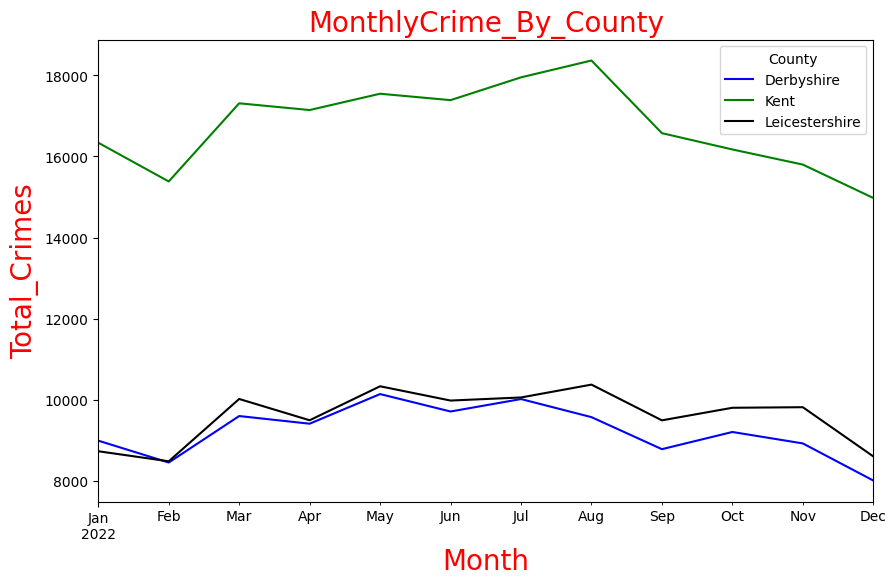

In [26]:
#Register the DataFrame as a temporary SQL tabel
countycrime_joined.createOrReplaceTempView("CrimePer_Month_County_linePlot")

#Writing a Spark SQL qurey to calculate the Monthly Cirme from each county
MonthlyCrime_LinePlot = spark.sql("""
SELECT County, Month, COUNT(*) as Crime_Count
FROM CrimePer_Month_County_linePlot
GROUP BY County,Month
ORDER BY Month
""").toPandas() #Here i conver Spark Data Frame to Pandas for easy plotting

#changing date in to Month for better readabilty
MonthlyCrime_LinePlot['Month'] = pd.to_datetime(MonthlyCrime_LinePlot['Month'])

# Pivot the data so that each County becomes a column, with Month as the index and Crime_Count as values
MonthlyCrime_LinePlot = MonthlyCrime_LinePlot.pivot(index='Month', columns='County', values='Crime_Count')

#Plot a line plot to visualize the Monthly Crime by Each County
MonthlyCrime_LinePlot.plot(figsize=(10,6), color=('blue', 'green', 'black'))
plt.xlabel('Month', fontsize=20, color='Red')
plt.ylabel('Total_Crimes', fontsize=20, color='Red')
plt.title('MonthlyCrime_By_County', fontsize=20, color='red')

#Diplay the Line Plot
plt.show()

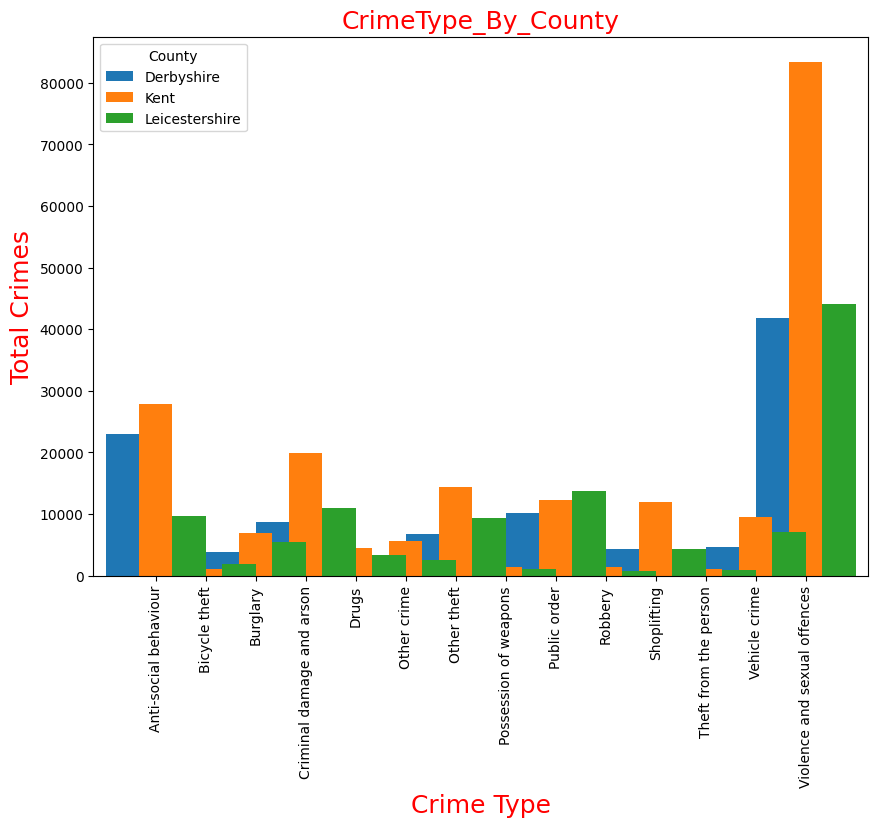

In [21]:
#Register the DataFrame as a temporary SQL tabel
countycrime_joined.createOrReplaceTempView("CrimeType_County_BarChart")

#Writing a Spark SQL qurey to calculate the Crime Type from each county
County_CrimeType = spark.sql("""
SELECT County, Crime_Type, COUNT(*) as Crime_Count
FROM CrimeType_County_BarChart
GROUP BY County, Crime_Type
ORDER BY County, Crime_Type
""").toPandas() #Here i conver Spark Data Frame to Pandas for easy plotting

# Pivot the data so that each County becomes a column, with Crime_Type as the index and Crime_Count as values
County_CrimeType = County_CrimeType.pivot(index='Crime_Type', columns='County', values='Crime_Count')

#Plot a Bar chart to visualize the Crime_Type by Each County
County_CrimeType.plot.bar(figsize=(10,7), width=2)
plt.xlabel('Crime Type', fontsize=18, color='red')
plt.ylabel('Total Crimes', fontsize=18, color='red')
plt.title('CrimeType_By_County', fontsize=18, color='red')

#Display Bar char
plt.show()

/tmp/ipykernel_30/3266145216.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(Derby_CrimeType))


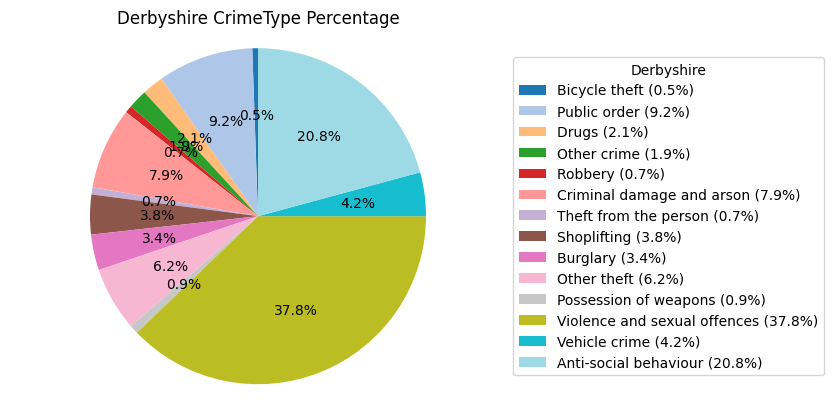

In [22]:
#Register the DataFrame as a temporary SQL tabel
countycrime_joined.createOrReplaceTempView("DerbyPieChart")

#Writing an SQL query to select the count of crimes by type for the 'Derbyshire' county
Derby_CrimeType = spark.sql("""
SELECT Crime_Type, COUNT(*) as Crime_Count
FROM DerbyPieChart
WHERE County = 'Derbyshire'
GROUP BY Crime_Type
""").toPandas()  #Here i conver Spark Data Frame to Pandas for easy plotting

# Calculate the percentage of each crime type
Derby_CrimeType['Percentage'] = 100 * Derby_CrimeType['Crime_Count'] / Derby_CrimeType['Crime_Count'].sum()

# Generate a colormap with 20 different colors for each crime type
colors = plt.cm.get_cmap('tab20', len(Derby_CrimeType))

# Create labels with both the crime type and its percentage for display in the legend box
box_label = [f"{crime_type} ({percentage:.1f}%)" for crime_type, percentage in zip(Derby_CrimeType['Crime_Type'], Derby_CrimeType['Percentage'])]

# Plot the pie chart with the crime counts and apply color mapping
plt.pie(Derby_CrimeType['Crime_Count'], autopct="%1.1f%%", colors=colors(range(len(Derby_CrimeType))), startangle=90)

# Add a legend to the chart, positioned to the left side of the plot
plt.legend(labels=box_label, title="Derbyshire", loc="center left", bbox_to_anchor=(1, 0.5))

# Set the title for the pie chart
plt.title("Derbyshire CrimeType Percentage")

# Ensure the pie chart is a perfect circle
plt.axis('equal')

# Display the pie chart
plt.show()





/tmp/ipykernel_30/2725475736.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(Leicester_CrimeType))


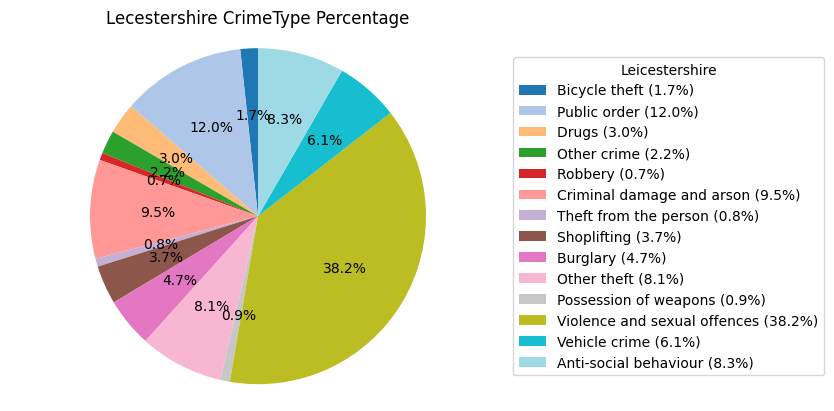

In [23]:
#Register the DataFrame as a temporary SQL tabel
countycrime_joined.createOrReplaceTempView("Leicester")

#Writing an SQL query to select the count of crimes by type for the 'Leicestershire' county
Leicester_CrimeType = spark.sql("""
SELECT Crime_Type, COUNT(*) as Crime_Count
FROM Leicester
WHERE County = 'Leicestershire'
GROUP BY Crime_Type
""").toPandas() #Here i conver Spark Data Frame to Pandas for easy plotting

# Calculate the percentage of each crime type
Leicester_CrimeType['Percentage'] = 100 * Leicester_CrimeType['Crime_Count'] / Leicester_CrimeType['Crime_Count'].sum()

# Generate a colormap with 20 different colors for each crime type
colors = plt.cm.get_cmap('tab20', len(Leicester_CrimeType))

# Create labels with both the crime type and its percentage for display in the legend box
box_label = [f"{crime_type} ({percentage:.1f}%)" for crime_type, percentage in zip(Leicester_CrimeType['Crime_Type'], Leicester_CrimeType['Percentage'])]

# Plot the pie chart with the crime counts and apply color mapping
plt.pie(Leicester_CrimeType['Crime_Count'], autopct="%1.1f%%", colors=colors(range(len(Leicester_CrimeType))), startangle=90)

# Add a legend to the chart, positioned to the left side of the plot
plt.legend(labels=box_label, title="Leicestershire", loc="center left", bbox_to_anchor=(1, 0.5))

# Set the title for the pie chart
plt.title("Lecestershire CrimeType Percentage")

# Ensure the pie chart is a perfect circle
plt.axis('equal')

# Display the pie chart
plt.show()





/tmp/ipykernel_30/4155128520.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(Kent_CrimeType))


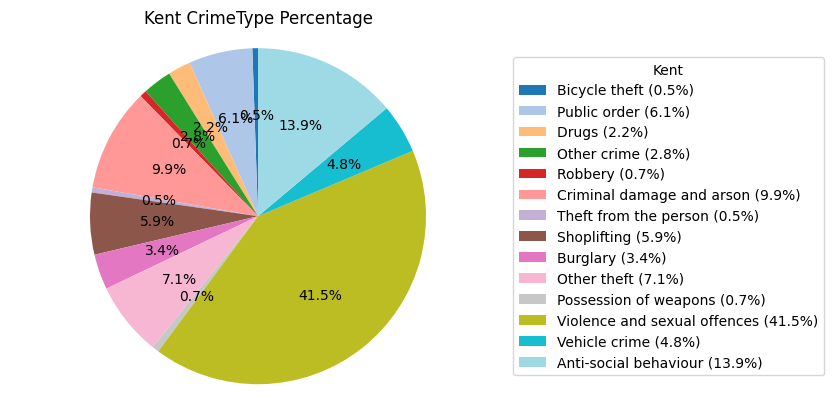

In [24]:
#Register the DataFrame as a temporary SQL tabel
countycrime_joined.createOrReplaceTempView("CrimeKent")

#Writing an SQL query to select the count of crimes by type for the 'Kent' county
Kent_CrimeType = spark.sql("""
SELECT Crime_Type, COUNT(*) as Crime_Count
FROM CrimeKent
WHERE County = 'Kent'
GROUP BY Crime_Type
""").toPandas() #Here i conver Spark Data Frame to Pandas for easy plotting

# Calculate the percentage of each crime type
Kent_CrimeType['Percentage'] = 100 * Kent_CrimeType['Crime_Count'] / Kent_CrimeType['Crime_Count'].sum()

# Generate a colormap with 20 different colors for each crime type
colors = plt.cm.get_cmap('tab20', len(Kent_CrimeType))

# Create labels with both the crime type and its percentage for display in the legend box
box_label = [f"{crime_type} ({percentage:.1f}%)" for crime_type, percentage in zip(Kent_CrimeType['Crime_Type'], Kent_CrimeType['Percentage'])]

# Plot the pie chart with the crime counts and apply color mapping
plt.pie(Kent_CrimeType['Crime_Count'], autopct="%1.1f%%", colors=colors(range(len(Kent_CrimeType))), startangle=90)

# Add a legend to the chart, positioned to the left side of the plot
plt.legend(labels=box_label, title="Kent", loc="center left", bbox_to_anchor=(1, 0.5))

# Set the title for the pie chart
plt.title("Kent CrimeType Percentage")

# Ensure the pie chart is a perfect circle
plt.axis('equal')

# Display the pie chart
plt.show()



